In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/445-CompPhoto-FinalProject')

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.interpolate
import scipy.sparse.linalg
from math import ceil as ceil
from math import floor as floor
import time

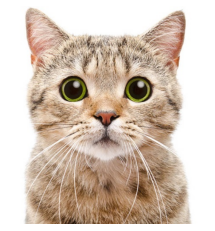

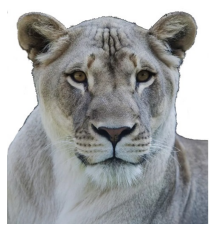

In [ ]:
def readImg(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0 # convert to float for other tasks
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.axis('off'), plt.show()
    plt.show()
    return img

img1=readImg('images/cat2.jpg')
img2=readImg('images/lion2.jpg')

In [ ]:
def mark_points(img):
    # get mask
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    fig = plt.figure(figsize=(7,7))
    fig.set_label('Mark feature points on object')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    xs = []
    ys = []
    clicked = []

    def on_mouse_pressed(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)
        plt.plot(x, y, 'r+')

    def onclose(event):
        clicked.append(xs)
        clicked.append(ys)
    
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    fig.canvas.mpl_connect('close_event', onclose)
    return clicked

In [ ]:
#load points from file
img1_points_array=np.genfromtxt('images/cat_points.txt')
img2_points_array=np.genfromtxt('images/lion_points.txt')

img1_points=[list(img1_points_array[:, 0]), list(img1_points_array[:, 1])]
img2_points=[list(img2_points_array[:, 0]), list(img2_points_array[:, 1])]

# OR mark new points

# %matplotlib notebook
# img1_points=mark_points(img1)

In [ ]:
# img2_points=mark_points(img2)

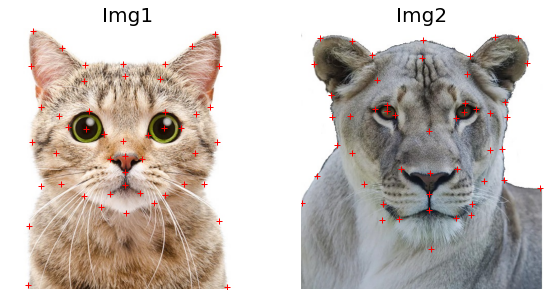

In [ ]:
#plot points on image
fig=plt.figure(figsize=(8,4), constrained_layout=True)

plt1=fig.add_subplot(121)
plt.imshow(img1)
plt1.set_title('Img1', fontsize=20)
plt.axis('off')
plt.plot(img1_points[0], img1_points[1], 'r+')

plt2=fig.add_subplot(122)
plt.imshow(img2)
plt2.set_title('Img2', fontsize=20)
plt.axis('off')
plt.plot(img2_points[0], img2_points[1], 'r+')


In [ ]:
def convert_points_array(img_points):
    img_points_array=np.zeros((len(img_points[0]), 2))
    img_points_array[:, 0]=np.array(img_points[0])
    img_points_array[:, 1]=np.array(img_points[1])
    return img_points_array
img1_points_array=convert_points_array(img1_points)
img2_points_array=convert_points_array(img2_points)

In [ ]:
#save points to file
# def save_points(path, points_array):
#     np.savetxt(path, points_array, fmt='%5.8f')

# save_points('images/cat_points.txt', img1_points_array)
# save_points('images/lion_points.txt', img2_points_array)

In [ ]:
avg_shape_points_array=(img1_points_array+img2_points_array)/2

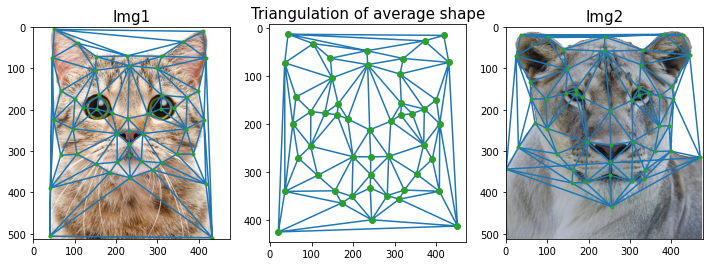

In [ ]:
from scipy.spatial import Delaunay

def get_delaunay(img1, img2, img1_points_array, img2_points_array, avg_shape_points_array):
    tri = Delaunay(avg_shape_points_array)
    
    fig=plt.figure(figsize=(12,4))

    plt1=fig.add_subplot(131)
    plt.imshow(img1)
    plt1.set_title('Img1', fontsize=15)

    plt.triplot(img1_points_array[:,0], img1_points_array[:,1], tri.simplices)
    plt.plot(img1_points_array[:,0], img1_points_array[:,1], '.')
    
    plt2=fig.add_subplot(133)
    plt.imshow(img2)
    plt2.set_title('Img2', fontsize=15)

    plt.triplot(img2_points_array[:,0], img2_points_array[:,1], tri.simplices)
    plt.plot(img2_points_array[:,0], img2_points_array[:,1], '.')

    plt2=fig.add_subplot(132)
    plt.triplot(avg_shape_points_array[:,0], avg_shape_points_array[:,1], tri.simplices)
    plt.plot(avg_shape_points_array[:,0], avg_shape_points_array[:,1], 'o')
    plt2.set_title('Triangulation of average shape', fontsize=15)
    ax=plt.gca()                            # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis

    return tri
    
avg_shape_tri=get_delaunay(img1, img2, img1_points_array, img2_points_array, avg_shape_points_array)

In [ ]:
def computeAffine(tri1_points, tri2_points):
    A=np.zeros((6, 6))
    b=np.zeros((6, 1))
    e=-1 #equation index
    for i in range(3):
        e+=1
        A[e, 0]=tri1_points[i, 0] #u
        A[e, 1]=tri1_points[i, 1] #v
        A[e, 2]=1
        b[e]=tri2_points[i, 0] #u'
        
        e+=1
        A[e, 3]=tri1_points[i, 0] #u
        A[e, 4]=tri1_points[i, 1] #v
        A[e, 5]=1
        b[e]=tri2_points[i, 1] #v'

    x = np.linalg.lstsq(A, b, rcond=None)
    A_sol=np.append(np.array(x[0].reshape(2,3)), [[0, 0, 1]], axis=0) #add [0 0 1] row to make it invertible
    return A_sol

In [ ]:
'''code for PointInTriangle adapted from https://blackpawn.com/texts/pointinpoly'''
def PointInTriangle(P, A,B,C):
  # Compute vectors        
  v0 = C - A
  v1 = B - A
  v2 = P - A

  # Compute dot products
  dot00 = np.dot(v0, v0)
  dot01 = np.dot(v0, v1)
  dot02 = np.dot(v0, v2)
  dot11 = np.dot(v1, v1)
  dot12 = np.dot(v1, v2)

  # Compute barycentric coordinates
  invDenom = 1 / (dot00 * dot11 - dot01 * dot01)
  u = (dot11 * dot02 - dot01 * dot12) * invDenom
  v = (dot00 * dot12 - dot01 * dot02) * invDenom

  # Check if point is in triangle
  return (u >= 0) and (v >= 0) and (u + v < 1)

In [ ]:
def tri_search(points_array, simplices, point):
    '''search point in triangulation defined by points_array and simplices
        return index of first triangle that matches. otherwise return -1'''
    num_simplices=simplices.shape[0]
    for i in range(num_simplices):
        A=points_array[simplices[i, 0]]
        B=points_array[simplices[i, 1]]
        C=points_array[simplices[i, 2]]
        if PointInTriangle(point, A,B,C)==True:
            return i
    return -1

Match: triangle index  45 points index  [24 23 22]


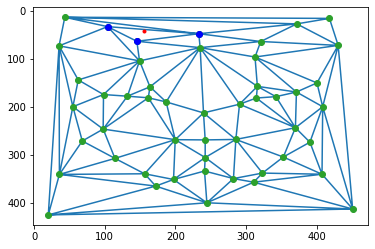

In [ ]:
from random import random
def randUnder(max):
    return int(random()*max)

testP=np.array(([randUnder(img1.shape[0]), randUnder(img1.shape[1])]))
search_result=tri_search(avg_shape_points_array, avg_shape_tri.simplices, testP)

if search_result==-1:
    print('No match')
else:
    print('Match: triangle index ', search_result, 'points index ', avg_shape_tri.simplices[search_result])
    plt.triplot(avg_shape_points_array[:,0], avg_shape_points_array[:,1], avg_shape_tri.simplices)
    plt.plot(avg_shape_points_array[:,0], avg_shape_points_array[:,1], 'o')
    plt.plot(avg_shape_points_array[avg_shape_tri.simplices[search_result][0],0], avg_shape_points_array[avg_shape_tri.simplices[search_result][0],1], 'bo')
    plt.plot(avg_shape_points_array[avg_shape_tri.simplices[search_result][1],0], avg_shape_points_array[avg_shape_tri.simplices[search_result][1],1], 'bo')
    plt.plot(avg_shape_points_array[avg_shape_tri.simplices[search_result][2],0], avg_shape_points_array[avg_shape_tri.simplices[search_result][2],1], 'bo')
    plt.plot(testP[0], testP[1], 'r.')
    ax=plt.gca()                            # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    plt.show()

In [ ]:
def bilinear_interp(x, y, img):
    assert len(img.shape)==2, 'img needs to be single-channel'
    x_frac=x%1
    y_frac=y%1
    if x_frac==0 and y_frac==0:
        return img[int(y), int(x)]
    else:
        A=np.array((1-x_frac, x_frac))
        B=np.array([[img[floor(y), floor(x)], img[ceil(y), floor(x)]], [img[floor(y), ceil(x)], img[ceil(y), ceil(x)]]])
        C=np.array([1-y_frac, y_frac]).transpose()
        return A.dot(B.dot(C))

In [ ]:
def warp(im, im_pts, dest_pts, tri):
    #compute affine matrix for each triangle
    print(' computing affine transformations...')
    num_simplices=tri.simplices.shape[0]
    A_inv_array=np.zeros((num_simplices, 3, 3))
    start=time.time()
    for i in range(num_simplices):
        A=computeAffine(im_pts[tri.simplices[i, :], :], dest_pts[tri.simplices[i, :], :])
        A_inv=np.linalg.inv(A)
        A_inv_array[i]=A_inv
    end=time.time()-start
    print('   finished in {} sec = {} min'.format(end, end/60))
        
    #map points in weghted avg shape to im
    print(' mapping points...')
    h, w, d=im.shape #get the dimensions from im
    
    #create a flattened array of pixel coordinates
    xs, ys=np.meshgrid(range(w), range(h))
    xs=xs.reshape((1, h*w))
    ys=ys.reshape((1, h*w))
    pts_map1=np.zeros((3, h*w)) #array for mapped points
    dest_min_x=dest_pts[:, 0].min()
    dest_max_x=dest_pts[:, 0].max()
    dest_min_y=dest_pts[:, 1].min()
    dest_max_y=dest_pts[:, 1].max()
    
    start=time.time()
    for i in range(h*w):
        #if the point is not in the range of points, skip the search
        if xs[0, i]<dest_min_x or xs[0, i]>dest_max_x or ys[0, i]<dest_min_y or ys[0, i]>dest_max_y:
          pts_map1[:, i]=np.array(([0, 0, 1])).transpose()
        else:
          result=tri_search(dest_pts, tri.simplices, np.array((xs[0, i], ys[0, i])))
          if result>-1: #if a triangle is found for the point, use the inverse affine matrix to map point to im
              pts_map1[:, i]=np.dot(A_inv_array[result], np.transpose(np.array((xs[0, i], ys[0, i], 1))))
          else: #if a triangle is not found, then it's a background pixel, so map to point (0,0)
              pts_map1[:, i]=np.array(([0, 0, 1])).transpose()
    pts_map1=pts_map1.transpose().reshape((h, w, 3)) #reshape mapped points array into h*w
    end=time.time()-start
    print('   finished in {} sec = {} min'.format(end, end/60))

    #interpolate pixel intensity
    print(' interpolating pixel intensity...')
    start=time.time()
    warped_im=np.zeros(im.shape)    
    for chan in range(3):
        for i in range(h):
            for j in range(w):
                warped_im[i, j, chan]= bilinear_interp(pts_map1[i, j][0], pts_map1[i, j][1], im[:,:,chan]) #im[round(pts_map1[i, j][1]), round(pts_map1[i, j][0]), chan]
    end=time.time()-start
    print('   finished in {} sec = {} min'.format(end, end/60))
            
    return warped_im

In [ ]:
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    assert im1.shape==im2.shape, 'Image 1 and image 2 need to have the same dimensions'
    
    weighted_avg_pts=(1-warp_frac)*im1_pts+warp_frac*im2_pts

    warped_im1=warp(im1, im1_pts, weighted_avg_pts, tri)
    warped_im2=warp(im2, im2_pts, weighted_avg_pts, tri)
    cross_dissolved=(1-dissolve_frac)*warped_im1 + dissolve_frac*warped_im2

    return cross_dissolved

In [ ]:
def morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames, start_frame, end_frame):
    h,w,d=im1.shape
    im_seq=np.zeros((end_frame-start_frame+1, h, w, d))
    for i in range(start_frame, end_frame+1):
        print('morphing frame {}/{}'.format(i, num_frames))
        im_seq[i-start_frame]=morph(im1, im2, im1_pts, im2_pts, tri, i/num_frames, i/num_frames)
    return im_seq

In [ ]:
my_morph_seq_47_61=morph_sequence(img1, img2, img1_points_array, img2_points_array, avg_shape_tri, 61, 47, 61)

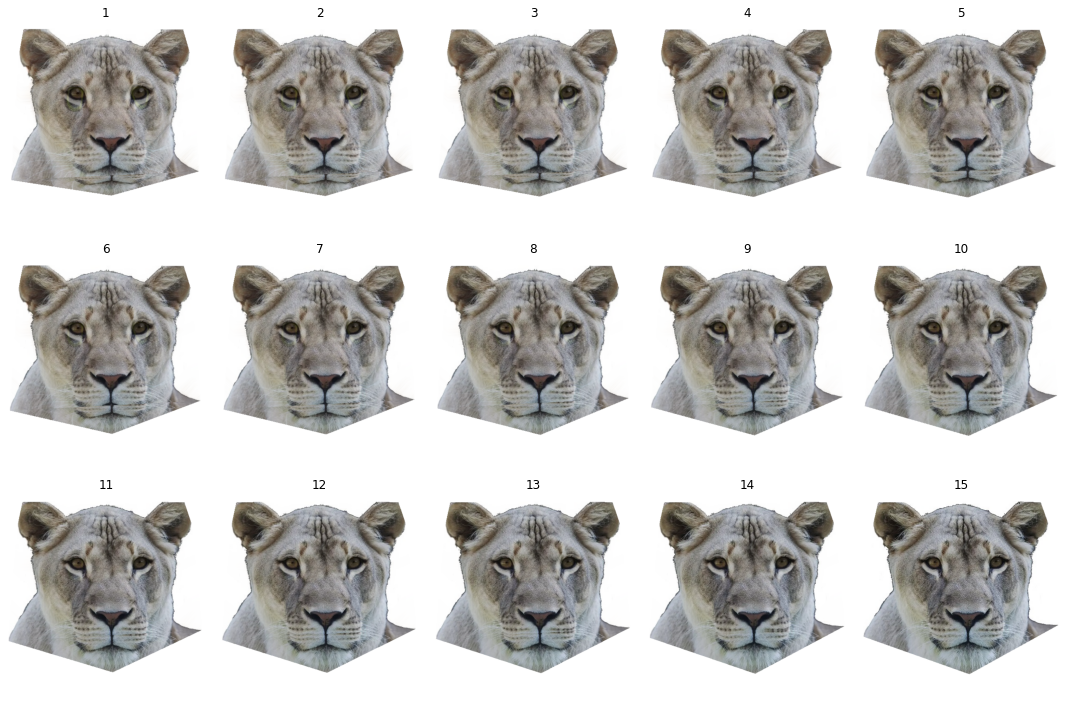

In [ ]:
def show_sequence(im_seq):
    n,h,w,d=im_seq.shape
    num_rows=ceil(n/5)
    num_cols=ceil(n/num_rows)
    k=1
    fig, axes=plt.subplots(num_rows, num_cols, figsize=(15,10))
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(im_seq[k-1])
            axes[i, j].axis('off')
            axes[i, j].set_title(k)
            k+=1
    plt.tight_layout()
    plt.show()
show_sequence(my_morph_seq_47_61)

In [ ]:
#crop images if height/width is odd
if img1.shape[0]%2==1:
    my_morph_seq_even=my_morph_seq[:, :-1 ,:,:]
else:
    my_morph_seq_even=my_morph_seq
if img1.shape[1]%2==1:
    my_morph_seq_even=my_morph_seq_even[:,:, :-1 ,:]

In [ ]:
my_morph_seq_16_30.shape

(16, 514, 476, 3)

In [ ]:
def save_sequence(morph_seq, path, start_frame, end_frame):
    if path[-1]!='/':
        path+='/'
    n=morph_seq.shape[0]
    for i in range(n):
        filepath=path+str(i+start_frame)+'.jpg'
        cv2.imwrite(filepath, (morph_seq[i][:, :, [2, 1, 0]] * 255).astype(np.uint8))
    print(str(n)+' images written to '+path)

save_sequence(my_morph_seq_47_61, 'images/output/', 47, 61)

15 images written to images/output/


In [ ]:
def rename(path, start_frame, end_frame):
  for i in range(start_frame, end_frame+1):
    os.rename(path+str(i)+'.jpg', path+"{:02d}".format(i)+'.jpg')
  print('Renamed {} files'.format(end_frame+1))
  
rename('images/output/', 47, 61)

Renamed 61 files


In [ ]:
!pip install ffmpeg-python

In [ ]:
import ffmpeg
(
    ffmpeg
    .input('images/output/*.jpg', pattern_type='glob', framerate=30)
    .output('images/output/cat_lion_morph.mp4')
    .run()
)

(None, None)